
Report:
*     Successfully Recovering Columns:
1. *     **regionidcity**
1. *     **regionidzip**
1. *     **propertycountylandusecode**
* 
*     Recovering Denied
1. *   **regionidneighborhood**
1. *   **propertyzoningdesc**
1. *   **censustractandblock**
* 
* Neutural (After Droping)
1. *   **propertycountylandusecode**
1. *   **propertylandusetypeid**
1. *   **regionidcounty**
1. *   **rawcensustractandblock**
* 
* Drop Missing
1. * **latitude**  OR **longitude**





ML algo:
**K-Nearest Neighbors** ( view method **fillna_knn** for detail )

Note:
* All the recovery do not consider the row with missing ***latitude*** and ***longitude*** values
* For those special row, just consider filling the latitude and longitude with north pole location i.e (N 90, ... ) and put some weird value to the geo columns. (merely don't want the value get recover by the knn algorithm )

In [1]:
import numpy as np
import pandas as pd
import gc
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import Matern, WhiteKernel
#from scipy.optimize import minimize
#from scipy.stats import norm


In [2]:
prop = pd.read_csv('../input/properties_2016.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
prop.columns.tolist() 

['parcelid',
 'airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',
 'firep

Those columns contain Geographic Information :
*     || *latitude* *longitude*
*     || *propertycountylandusecode* *propertylandusetypeid* *propertyzoningdesc*
*     || *regionidcity* *regionidcounty* *regionidneighborhood* *regionidzip*
*     || *censustractandblock* *rawcensustractandblock*

In [4]:
geocolumns = [  'latitude', 'longitude'
                            ,'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc'
                            ,'regionidcity','regionidcounty', 'regionidneighborhood', 'regionidzip'
                            ,'censustractandblock', 'rawcensustractandblock']

In [5]:
geoprop = prop[geocolumns]
del prop; gc.collect()

21

Find out the most completed column which could be use as a reference to impute the missing value

latitude                       11437
longitude                      11437
propertycountylandusecode      12277
propertylandusetypeid          11437
propertyzoningdesc           1006588
regionidcity                   62845
regionidcounty                 11437
regionidneighborhood         1828815
regionidzip                    13980
censustractandblock            75126
rawcensustractandblock         11437
dtype: int64

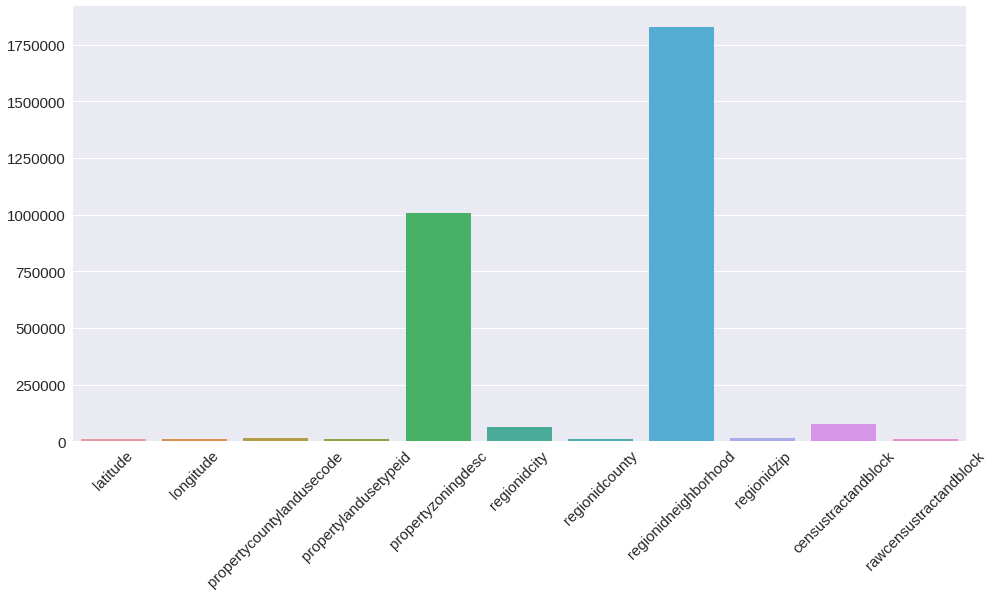

In [6]:
missingcount = geoprop.isnull().sum(axis=0)
plt.figure( figsize = (16,8) )
plot= sns.barplot( x = geocolumns,y = missingcount.values )
plt.setp( plot.get_xticklabels(), rotation = 45 )
missingcount

**Seems like we have 7 candidational columns **
Recalled from Geo101, latitude and longitude is the basic info and enough info to tell a location. Every pair of lat and lon refer to a percise location on the earth. Therefore, in here we take latitude and longitude as bases.

**Let's find the correlation between the missing values**

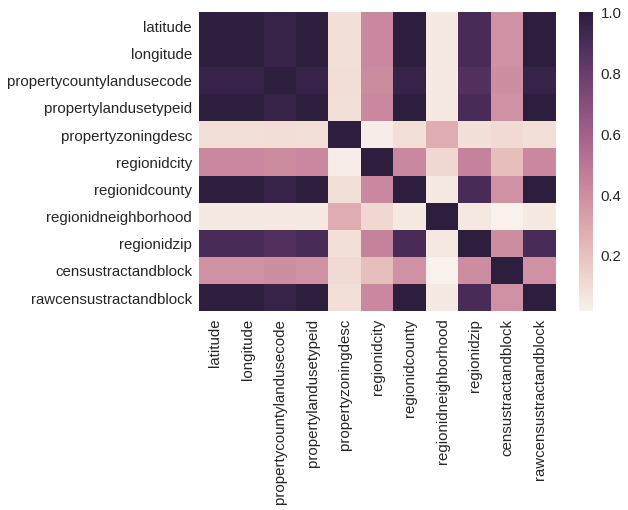

In [7]:
corr = geoprop.isnull().corr()
sns.heatmap( corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values ) 

**Seems like the missing *latitude* ,*longitude* values cause the missing of *rawcensustractandblock*, *regionidzip*, *regionidcounty*, *propertylandusetypeid*, *propertycountylandusecode* values, observing from the bottom to the top.    **                                

In [8]:
# let's clean the row without the latitude and longitude value
geoprop.dropna( axis = 0, subset = [ 'latitude', 'longitude' ], inplace = True )

Okay, let see where are those real estates located in

In [9]:
geoprop.loc[:,'latitude'] = geoprop.loc[:,'latitude']/1e6
geoprop.loc[:,'longitude'] = geoprop.loc[:,'longitude']/1e6

maxlat = (geoprop['latitude']).max()
maxlon = (geoprop['longitude']).max()
minlat = (geoprop['latitude']).min()
minlon = (geoprop['longitude']).min()
print('maxlat {} minlat {} maxlon {} minlon {}'.format(maxlat, minlat, maxlon, minlon))

CAparms = { 'llcrnrlat' : minlat,
                     'urcrnrlat' : maxlat+0.2,
                     'llcrnrlon' : maxlon-2.5,
                     'urcrnrlon' :minlon+2.5 }

maxlat 34.81965 minlat 33.324388 maxlon -117.554316 minlon -119.47578


print( geoprop['regionidcity'].nunique() )
print( geoprop['regionidcity'].unique())

In [10]:
from mpl_toolkits.basemap import Basemap, cm

In [11]:
def create_basemap( llcrnrlat=20,urcrnrlat=50,llcrnrlon=-130,urcrnrlon=-60, figsize=(16,9) ):
    fig=plt.figure( figsize = figsize )
    Bm = Basemap( projection='merc', 
                llcrnrlat=llcrnrlat,urcrnrlat=urcrnrlat,
                llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,
                lat_ts=20,resolution='i' )
    # draw coastlines, state and country boundaries, edge of map.
    Bm.drawcoastlines(); Bm.drawstates(); Bm.drawcountries() 
    return Bm, fig    

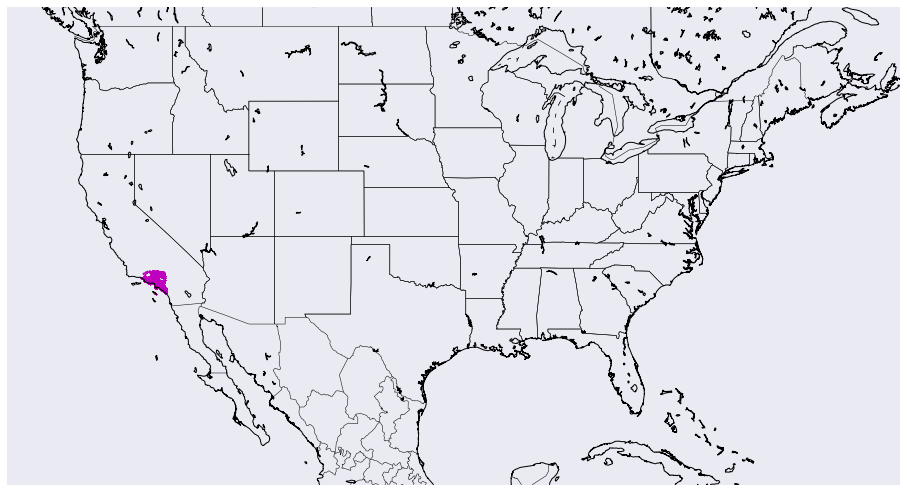

In [12]:
Bm, fig = create_basemap()
x,y = Bm( geoprop['longitude'].values, geoprop['latitude'].values)                           
Bm.scatter( x, y, marker = 'D',color = 'm', s = 1 )
plt.show()

Wow, CA! Zoom in and see what happen

hardcoding the locations of the main cities in CA

In [13]:
citydict = {}
citydict['Los Angle'] = [ 34.088537, -118.249923 ]
citydict['Anaheim'] = [ 33.838199,  -117.924770 ]
citydict['Irvine'] = [ 33.683549,  -117.793723 ]
citydict['Long Beach'] = [ 33.778341,  -118.285261]
citydict['Oxnard'] = [ 34.171196, -119.165045 ]
citydict['Ventura'] = [ 34.283106, -119.225597 ]
citydict['Palmdale'] = [34.612009, -118.127173]
citydict['Lancaster'] = [34.719710, -118.135903]
citydict['Hesperia'] = [34.420196, -117.289121]
citydict['Riverside'] = [33.972528, -117.405517]


In [14]:
def plot_maincities( Bm, citydict ):
    for key, values in citydict.items():
        x , y = Bm( values[1], values[0] )
        Bm.plot( x, y, 'bo', markersize = 5)
        plt.text( x+3000, y+3000, key )    

In [15]:
def view_missing( df, target,see_known=True ,ignorefirst = False ):


    Bm, fig = create_basemap( **CAparms )

    # plot the known data
    if see_known:
        notmiss_df = df.loc[ df[target].notnull() ]
        groupby = notmiss_df.groupby(target)
        groups = [ groupby.get_group(g) for g in groupby.groups ]
        groups = groups[1:] if ignorefirst else groups 
        print( 'num groups:  ', len( groups ) )
        for group in groups:
            x,y = Bm( group['longitude'].values, group['latitude'].values )  
            Bm.scatter( x, y,  marker = 'D', s = 1 )

    # plot the missing data
    missing_target = df[target].isnull()
    if missing_target.any():
        print( '{} missing value at column: {}'.format( missing_target.sum(), target ) )
        missing = df.loc[ missing_target, ['latitude','longitude'] ]
        x,y = Bm( missing['longitude'].values, missing['latitude'].values )  
        Bm.scatter( x, y,  marker='D',s = 3, color = 'yellow', alpha = 0.1 )
    else:
        print('zero missing value at column: ', target )
        
    Bm.drawcounties( color='b', linewidth=0.3 )

    plot_maincities( Bm, citydict )

    plt.show()

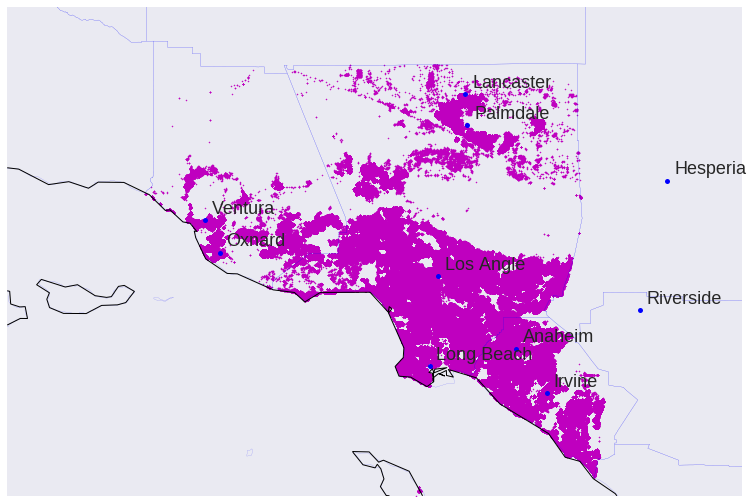

In [16]:
Bm, fig = create_basemap( **CAparms )

x , y = Bm( geoprop['longitude'].values, geoprop['latitude'].values ) 

Bm.scatter(x,y , marker='D',color='m',s=1 )
Bm.drawcounties(color='b')

plot_maincities( Bm, citydict )

plt.show()

Whoa, It basically cover the cites around Los Angle and some of those are far way from the urban erea meaning that it not belongs to any big city.


Let's check our assumption 

**Plot the location where missing the 'regionidcity' values**

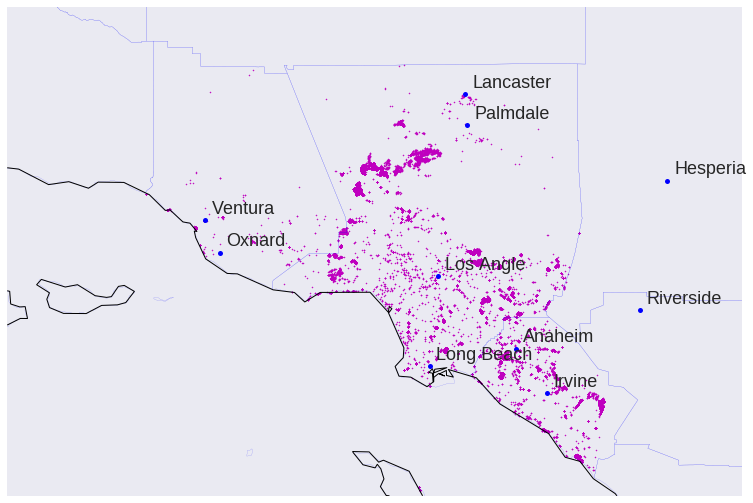

In [17]:
misscity = geoprop['regionidcity'].isnull()

Bm, fig = create_basemap( **CAparms )

x,y = Bm( geoprop.loc[ misscity, 'longitude' ].values, geoprop.loc[ misscity,'latitude' ].values )                        

#plot the property
Bm.scatter(x, y , marker = 'D',color = 'm',s = 1 )
Bm.drawcounties( color = 'b' )

#plot the location of the main cities
plot_maincities( Bm, citydict )

plt.show()


My assumption is wrong, the values is just randomly missing.......


Let's plot the location before we fill the missing value

num groups:   186
51408 missing value at column: regionidcity


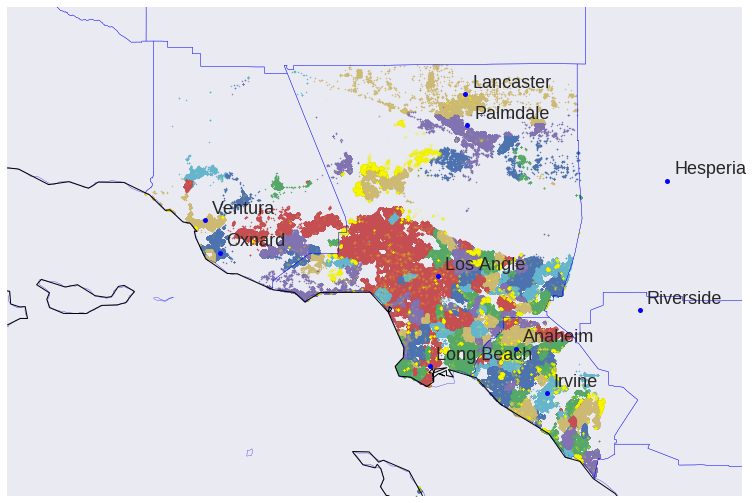

In [18]:
view_missing( geoprop, 'regionidcity', ignorefirst = False )

Let's fill those values

In [19]:
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder

def fillna_knn( df, base, target, fraction = 1, threshold = 10 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = 10
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'perdicting' )
    Z = clf.predict(geoprop.loc[ miss, base  ])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df' )    
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
        return enc
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )
        

In [20]:
fillna_knn( df = geoprop,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity', fraction = 0.15 )

fitting
the shape of active features:  (186,)
perdicting
writing result to df
num of unperdictable data:  72.0


OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

Let's see how well the KNN do on the recovery

In [21]:
groupscity = geoprop.groupby('regionidcity')
groups =[ groupscity.get_group(x) for x in groupscity.groups ]
print('num groups : ',len(groups))

num groups :  187


In [22]:
groups[0].regionidcity.values[0]
del groups, groupscity ; gc.collect()

32476

0.0 means the knn could not find a suitable city id for that pair of latitude and longitude 
So we just ignore the first group

num groups:   186
zero missing value at column:  regionidcity


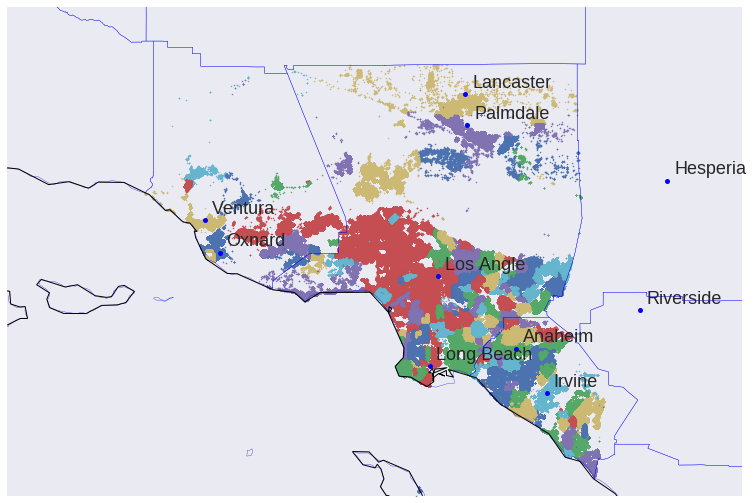

In [23]:
view_missing( geoprop, 'regionidcity', ignorefirst = True )

After fullfillign the regionidcity, let's check what columns are left 

In [24]:
missingcount = geoprop.isnull().sum(axis=0)
missingcount[missingcount>0]

propertycountylandusecode        840
propertyzoningdesc            995151
regionidneighborhood         1817378
regionidzip                     2543
censustractandblock            63689
dtype: int64

**The columns still have missing values are**
1. *propertycountylandusecode*
2. *propertyzoningdesc*
3. *regionidneighborhood*
4. *regionidzip*
4. *censustractandblock*                         

Let's deal with *regionidzip* first. We could apply the same trick onto *regionidzip* as well as *regionidcity*

In [25]:
fillna_knn( df = geoprop,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip', fraction = 0.1 )

fitting
the shape of active features:  (395,)
perdicting
writing result to df
num of unperdictable data:  3.0


OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [26]:
missingcount = geoprop.isnull().sum( axis = 0 )
missingcount[ missingcount>0 ]

propertycountylandusecode        840
propertyzoningdesc            995151
regionidneighborhood         1817378
censustractandblock            63689
dtype: int64

Let's analyse the regionidneighborhood.
This data is simply means community identity

In [27]:
print('The number of categories : ' ,geoprop.regionidneighborhood.nunique())
print(geoprop.regionidneighborhood.value_counts().head() )

The number of categories :  528
118208.0    32267
268496.0    23186
48570.0     21186
27080.0     18891
37739.0     18645
Name: regionidneighborhood, dtype: int64


let's plot it on the map 

num groups:   528
1817378 missing value at column: regionidneighborhood


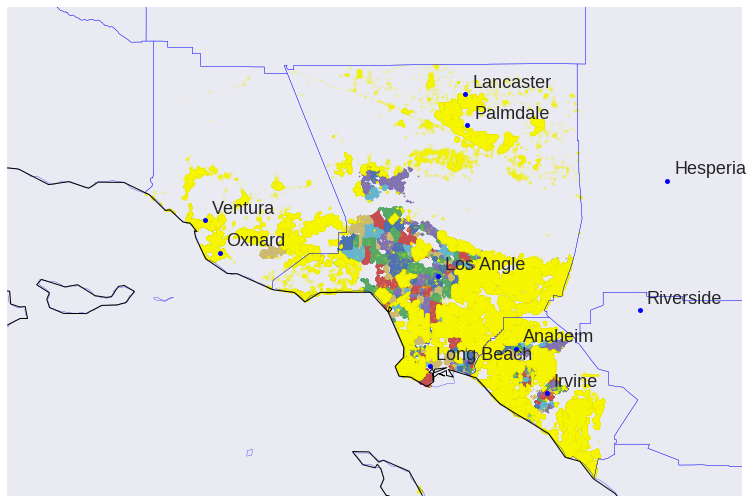

In [28]:
view_missing( geoprop, 'regionidneighborhood', ignorefirst = False )

Seems like the map is got contaminated by the highlighter (tells where the neighborhood data is missing ) . Does it merely means most of the properties actually don't have a community?
If so, would it affact the performance of the zillow model? I would left this question until I fullfill all the missing geodata

But after I conduct an Investigation on the neighborhood in Lancaster CA, I found there are at least **63** neighborhood in Lancaster. 

Whoa... It is impossible to recover the missing neighborhood data with the original data.... Hope there would be a version_3 could complete the neighborhood data

Now, let's take a break and move on to the *propertycountylandusecode*

Let's look at the definition first:
     County land use code i.e. it's zoning at the county level
     Okay, would it means the land use code describe in that county's land use law?
Takes a look at the L.A. county code:
     
>      22.52.3450 - Permitted Land Use.	
>         Eligible land uses under the UAIZ Program may include any agricultural land uses that are permitted or conditionally permitted both by the Act and by local regulations, including local planning and zoning codes

 URL:     https://library.municode.com/ca/los_angeles_county/codes/code_of_ordinances?nodeId=TIT22PLZO_DIV1PLZO_CH22.52GERE_PT31URAGINZOPR_22.52.3450PELAUS

So it is the zooning codes designed by the local government for limited reason...

Let's examine the zooning code used by three different county in our data.

In [29]:
groupby_county = geoprop.groupby('regionidcounty')
groups = [ groupby_county.get_group(g) for g in groupby_county.groups ]
print('num groups : ', len(groups))
for g in groups:
    print( 'num unique ', g.propertycountylandusecode.nunique() )
    print( g.propertycountylandusecode.unique() )
    print('----------------------------------------------------------------------')

num groups :  3
num unique  20
['1' '128' '0' '122' '38' '135' '96' '71' '73' '34' '105' nan '8' '5' '3'
 '84' '2' '91' '36' '4' '76']
----------------------------------------------------------------------
num unique  30
['1112' '5050' '1110' '1118' '1111' '1129' '1420' '1222' '1128' '1210'
 '1310' '1117' '1333' '1116' '1410' '1014' '1321' '1444' '1421' '1120'
 '5060' '1012' '1432' '1119' '9000' '6050' '1011' '9100' '1013' '5011' nan]
----------------------------------------------------------------------
num unique  191
['010D' '0109' '1200' '1210' '010V' '300V' '0100' '0200' '010C' '0300'
 '1204' '100V' '01HC' '120C' '040V' '1214' '0101' nan '070P' '0700' '010E'
 '0104' '070D' '0108' '012C' '0400' '0103' '01DC' '0201' '010M' '030V'
 '0110' '010F' '010G' '010H' '0301' '0102' '020E' '020M' '0401' '0113'
 '0141' '0209' '040G' '010L' '012E' '0111' '1720' '012D' '1213' '1201'
 '0140' '0123' '0133' '020G' '030G' '0204' '010T' '0120' '1202' '121G'
 '010X' '020V' '880V' '0130' '0118' '01HE' '

Three county use three different type of code, great discovery. Maybe we could split the data into groups by counties.

Let's see how well it is missing. 

num groups:   240
840 missing value at column: propertycountylandusecode


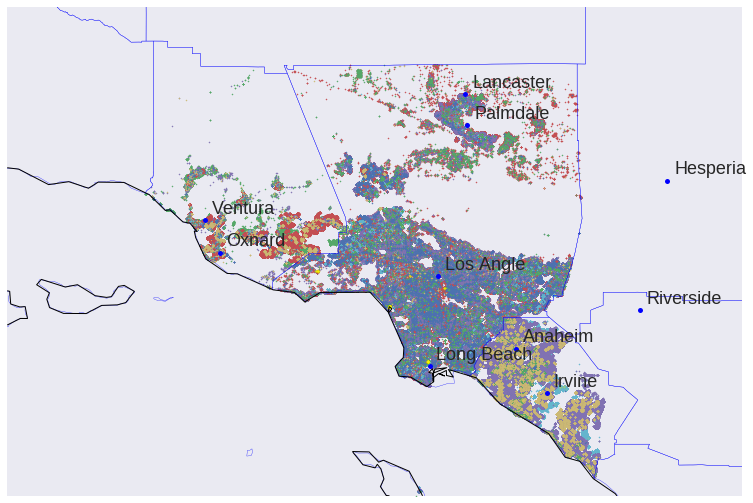

In [30]:
view_missing( geoprop, 'propertycountylandusecode', ignorefirst = False )

Not much missing, same trick could work also. 

* One more step needed is: converting the datatype from mixture to numerical datatype. 

In [31]:
from sklearn.preprocessing import LabelEncoder

def zoningcode2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    print('fit and transform')
    df[ target ]= enc.fit_transform( df[ target ].values )
    print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
    print('recover the nan value')
    return enc


In [32]:
zoningcode2int( df = geoprop,
                            target = 'propertycountylandusecode' )

fit and transform
num of categories:  (241,)
recover the nan value


LabelEncoder()

In [33]:
geoprop.propertycountylandusecode.nunique()

240

In [34]:
enc=fillna_knn( df = geoprop,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertycountylandusecode', fraction = 0.1 )

fitting
the shape of active features:  (142,)
perdicting
writing result to df
num of unperdictable data:  0.0


We get only around 140 active features which are far away from the total features. Maybe the remaining 100 feature just not show up frequently in the dataset. 

In [35]:
geoprop.propertycountylandusecode.value_counts().tail(100)

50.0     4
81.0     4
45.0     4
48.0     4
33.0     3
37.0     3
85.0     3
49.0     3
1.0      3
175.0    3
95.0     3
227.0    3
157.0    3
113.0    3
169.0    2
210.0    2
176.0    2
239.0    2
213.0    2
19.0     2
181.0    2
212.0    2
22.0     2
170.0    2
131.0    2
117.0    2
134.0    2
136.0    2
27.0     2
201.0    2
        ..
73.0     1
74.0     1
107.0    1
79.0     1
62.0     1
80.0     1
83.0     1
97.0     1
96.0     1
88.0     1
92.0     1
119.0    1
121.0    1
173.0    1
149.0    1
40.0     1
42.0     1
44.0     1
161.0    1
90.0     1
155.0    1
138.0    1
122.0    1
53.0     1
54.0     1
133.0    1
126.0    1
124.0    1
123.0    1
120.0    1
Name: propertycountylandusecode, Length: 100, dtype: int64


For this column **propertyzoningdesc ** the information behind the code could refer to: 
> Standard Land Use Code
> https://www.austintexas.gov/sites/default/files/files/Planning/zoning_landuse_chart.pdf

> http://planning.lacounty.gov/luz/summary/category/industrial_zones
> 
> https://www.zillow.com/advice-thread/what-is-LAR-1-and-LAR-3-zoning/285772/

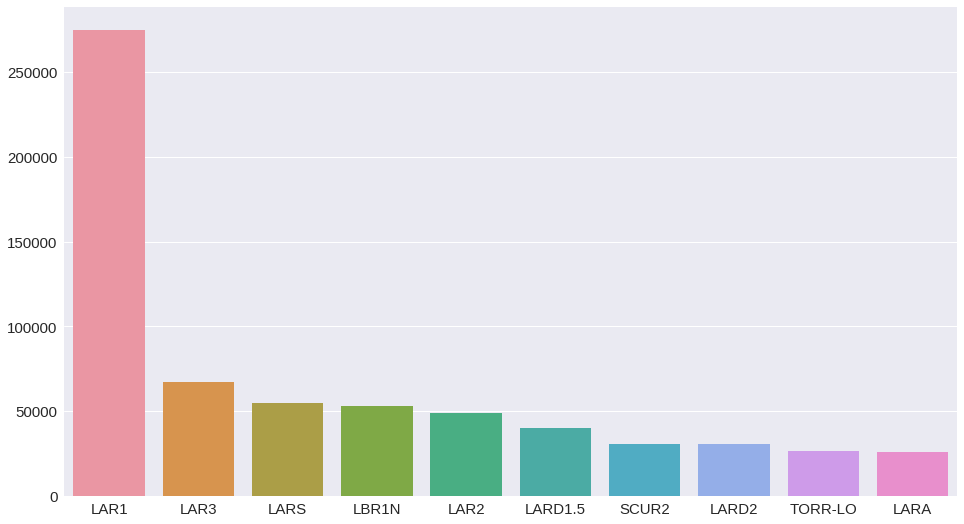

In [36]:
vc = geoprop.propertyzoningdesc.value_counts()
fig = plt.figure(figsize=((16,9)))
sns.barplot( x = vc.index[:10], y = vc.values[:10] )

LAR1 may refer to Los Angle R-1 zoning

num groups:   5638
995151 missing value at column: propertyzoningdesc


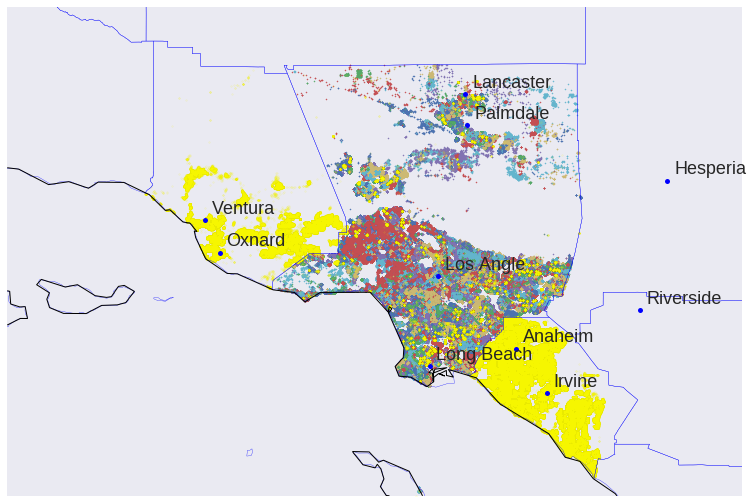

In [37]:
view_missing(geoprop,'propertyzoningdesc')

Only thing I know is that the zillow team still has potiontial  find the description .


What about the last one

63689 missing value at column: censustractandblock


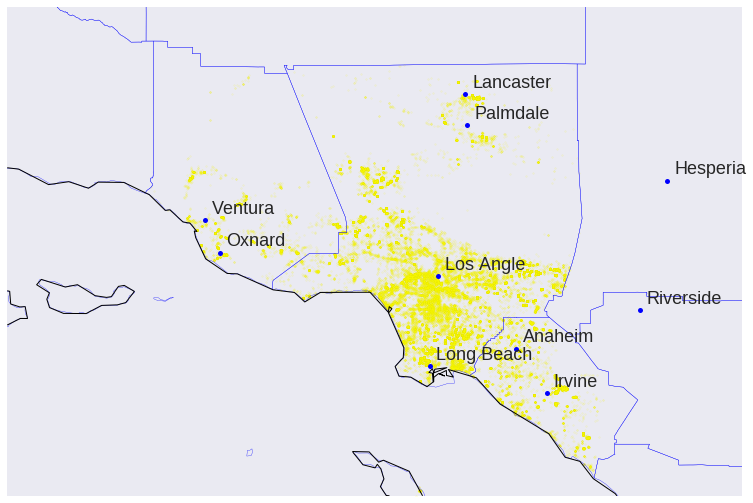

In [38]:
view_missing(geoprop,'censustractandblock',see_known=False)

... Another bad news, please drop it. 

------------------------------------------------------**The End**-------------------------------------------------------

Please left your comment below if there are anything confuse you or just for sharing your insight of the data :-)